# T2 SME0104 - Cálculo Numérico
## Recomendação de filmes com SVD

Alunos: 
- Kauê Hunnicutt Bazilli - 11212226
- Matheus Vieira Gonçalves - 11200397
- Pedro Henrique dias Junqueira de Souza - 11294312

# Explicação
O projeto desenvolvido foi um decodificador de sinais DTMF, os sinais DTMF são aqueles famosos tons que tocam ao digitarmos números telefônicos, cada número corresponde na verdade a dois tons um de baixa e um de alta frequência que eram decodificados ao chegar na central.

O objetivo do trabalho é criar um decodificador capaz de interpretar o som recebido utilizando o métodos dos mínimos quadrados e converter no som carácter original pressionado.

In [2]:
# Remover os comentários para instalar as bibliotecas necessárias
# import sys
# !{sys.executable} -m pip install sounddevice
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib

import pandas as pd
import numpy as np
from scipy.ndimage import zoom
import sounddevice as sd
import matplotlib.pyplot as pp
import math


Aqui definimos diversas constantes que serão utilizadas ao longo do código

In [31]:

SAMPLE_RATE = 22000  # taxa de gravação
REC_TIME = 10.0  # segundos
FRAMES = int(REC_TIME * SAMPLE_RATE)  # quantidade de frames da gravação
CHANNELS = 1  # quantidade de canais, 1 significa mono

# menor quantidade de tempo significativo durante a gravação
DELTA_T = 1.0 / SAMPLE_RATE

# Frequências DTMF
DTMF_LOW_FREQUENCIES = np.array([697, 770, 852, 941])  # Hz
DTMF_HIGH_FREQUENCIES = np.array([1209, 1336, 1477, 1633])  # Hz

DTMF_FREQUENCIES = np.concatenate(
    [DTMF_LOW_FREQUENCIES, DTMF_HIGH_FREQUENCIES])  # Hz

"""
        1209Hz	1336Hz	1477Hz	1633Hz
697Hz	    1	    2	    3	    A
770Hz	    4	    5	    6	    B
852Hz	    7	    8	    9	    C
941Hz	    *	    0	    #	    D
"""

DTMF_DICT = np.array(
    [['1', '2', '3', 'A'],
     ['4', '5', '6', 'B'],
     ['7', '8', '9', 'C'],
     ['*', '0', '#', 'D']])


In [41]:
# inicia a gravação do áudio
sound_wave = sd.rec(frames=FRAMES,
                    samplerate=SAMPLE_RATE,
                    channels=CHANNELS)

sd.wait()  # espera a gravação encerrar
SOUND_WAVE_ROWS, SOUND_WAVE_COLS = sound_wave.shape
print(type(sound_wave), sound_wave.shape)


<class 'numpy.ndarray'> (220000, 1)


In [42]:

sd.play(sound_wave, samplerate=SAMPLE_RATE)  # toca o audio gravado
sd.wait()  # espera o audio encerrar


KeyboardInterrupt: 

In [52]:
def reject_outliers(data, m = 3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

def moving_average(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

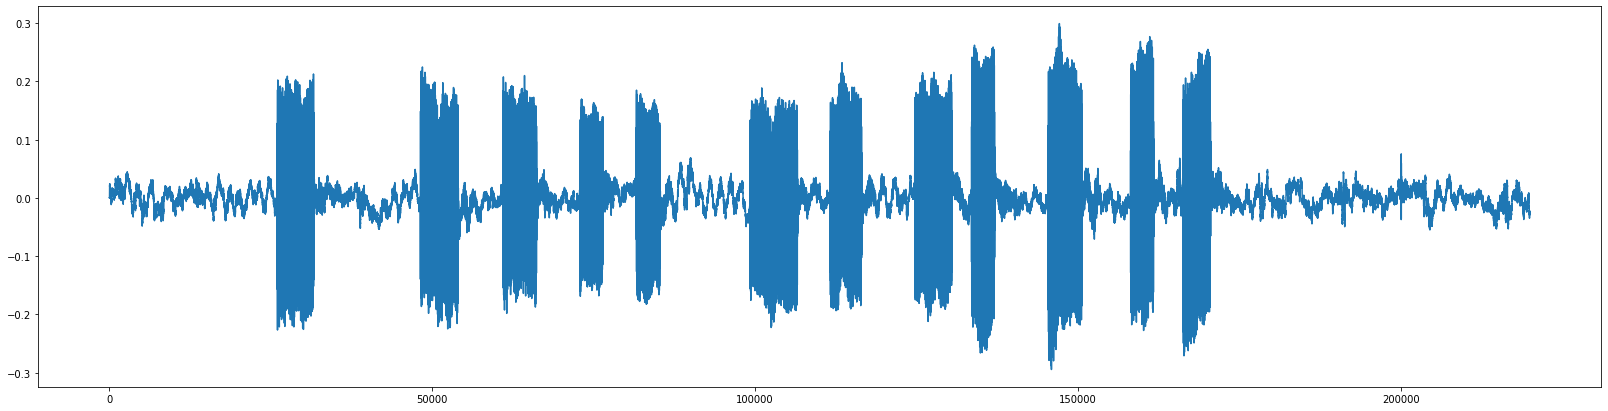

In [49]:

pp.figure(figsize=(28,7))
pp.plot(sound_wave)
pp.show()

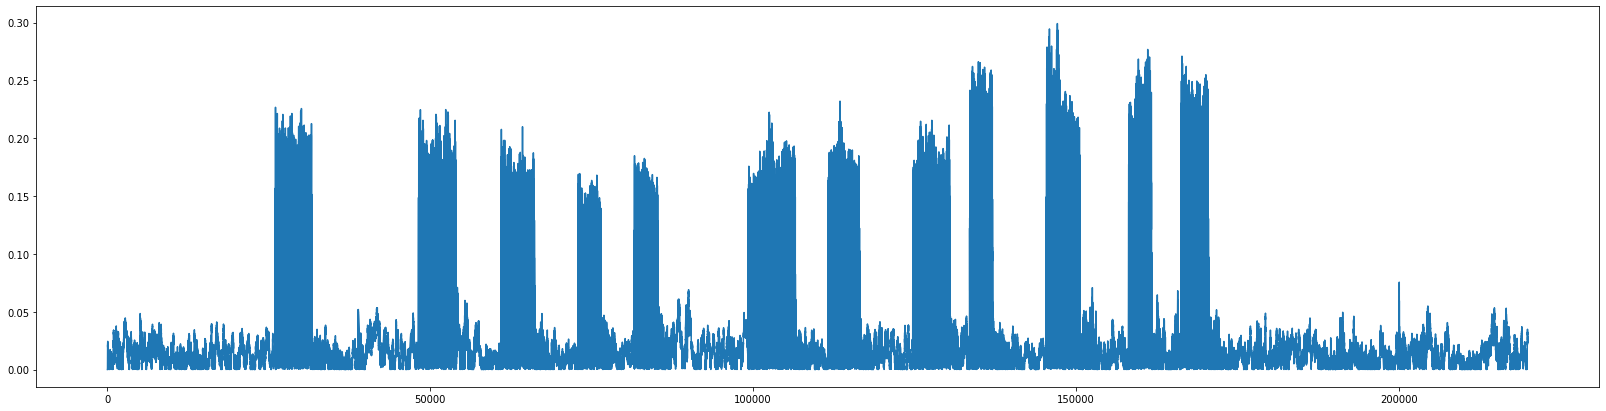

In [55]:

pp.figure(figsize=(28,7))
pp.plot(np.absolute(sound_wave))
pp.show()

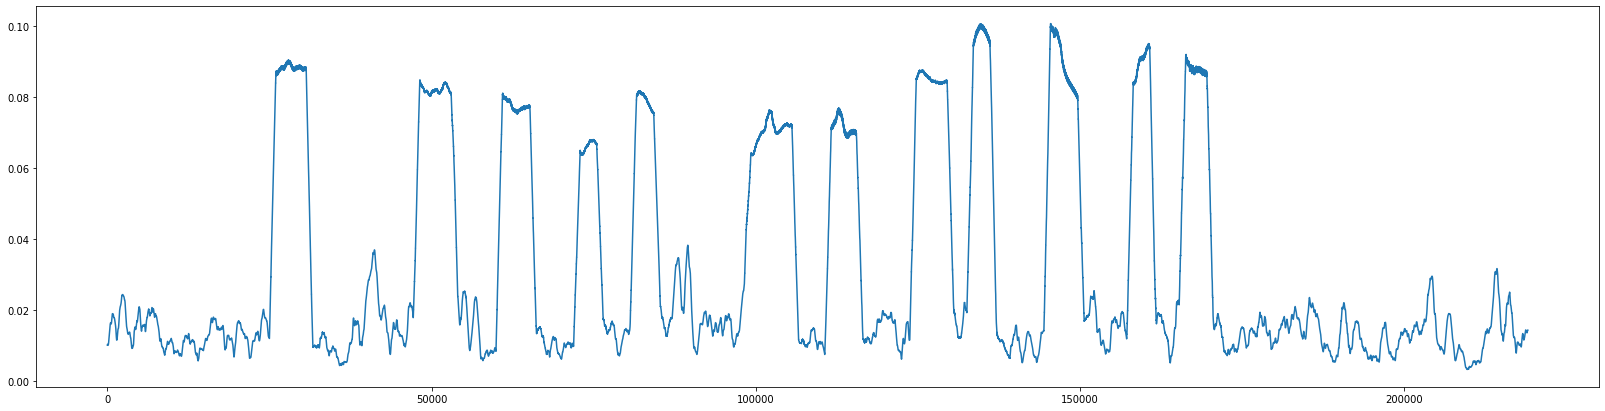

In [56]:

filtered_sound_wave = moving_average(np.absolute(sound_wave))

pp.figure(figsize=(28,7))
pp.plot(filtered_sound_wave)
pp.show()

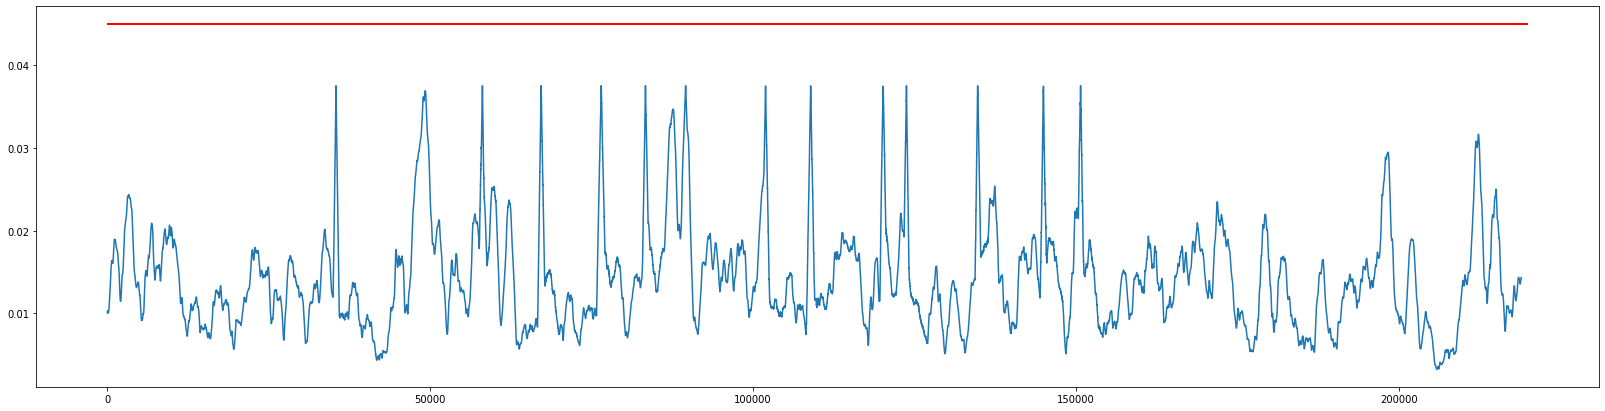

In [65]:
silence_wave = reject_outliers(filtered_sound_wave)
silence_wave = zoom(silence_wave,len(filtered_sound_wave)/len(silence_wave))

silence_max_threshold = np.max(silence_wave) * 1.2;

pp.figure(figsize=(28,7))
pp.plot(silence_wave)
pp.hlines(silence_max_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()

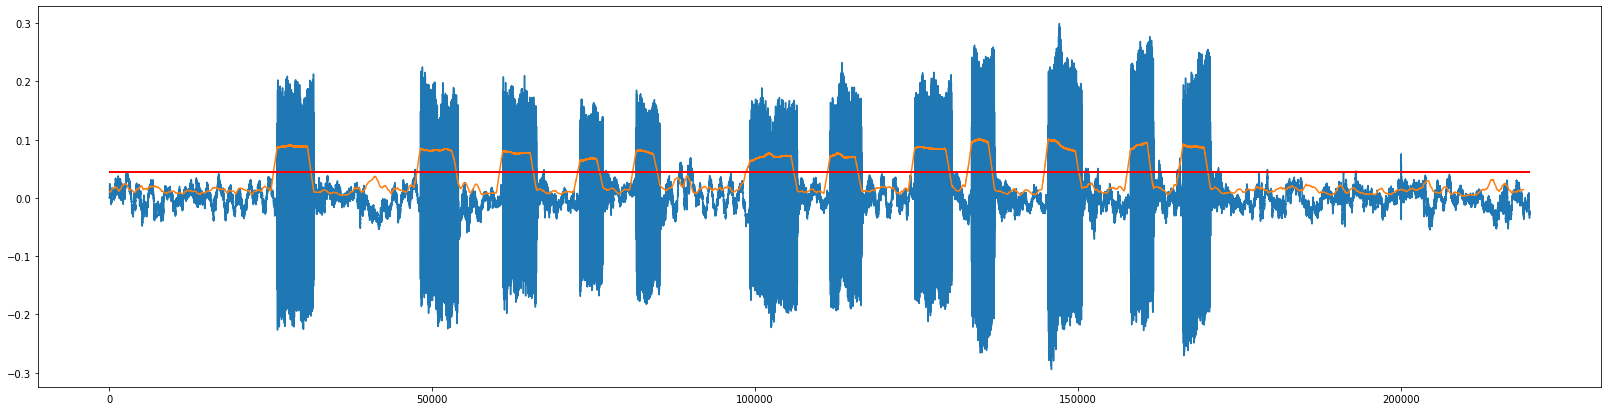

In [66]:
# visualização do audio gravado



pp.figure(figsize=(28,7))
pp.plot(sound_wave)
pp.plot(filtered_sound_wave)
pp.hlines(silence_max_threshold,xmin=-1,xmax=[len(sound_wave)], color='r', linewidth=2)
pp.show()


O audio gravado pode ser descrito como:

$$
S(t) = \sum_{n=1}^{8} A_n \times \sin{ (\phi_n 2\pi t + \sigma_n)}
$$

Sendo $A$ a amplitude de cada frequência $n$, e $\sigma_n$ a fase de cada um dos sinais. Utilizando o seno da soma, podemos desenvolver essa expressão para:


$$
S(t) = \sum_{n=1}^{8} A_n [\sin{(\phi_n 2\pi t)}\cos{(\sigma_n)} + \sin{(\sigma_n)}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} [\underbrace{A_n \cos(\sigma_n)}_{x_{2n-1}}\sin{(\phi_n 2\pi t)}
 + \overbrace{A_n \sin{(\sigma_n)}}^{x_{2n}}\cos{(\phi_n2\pi t)}] \\
S(t) = \sum_{n=1}^{8} x_{2n-1}\sin{(\phi_n 2\pi t)} + \sum_{n=1}^{8} x_{2n}\cos{(\phi_n2\pi t)}, \; A_n = \sqrt{x_{2n}^2 + x_{2n-1}^2}
$$

Logo assim podemos ver que teremos 16 equações com diferentes coeficientes para serem encontrados, o que podemos fazer aplicando a técnica de mínimos quadrados. Aqueles que tiverem as maiores amplitudes serão os relacionados ao digito que buscamos

In [141]:
#simplificação, ao invés de criarmos 16 funções diferentes podemos criar apenas essa
def mmq(time, n):
    frequency = int(n/2)
    val = DTMF_FREQUENCIES[frequency] * math.pi * 2 * time
    return math.sin(val) if (n % 2 == 0) else math.cos(val)


A = np.zeros(shape=(SOUND_WAVE_ROWS, 16))
for i in range(0, SOUND_WAVE_ROWS):
    for j in range(0, 16):
        A[i][j] = mmq(i * DELTA_T, j)


Utilizando as equações normais temos que $\hat{x}$ é uma solução para $ Ax = B <=> A^{T}A \hat{x} = A^{T}b$ 

In [142]:

A_T = A.T

A_T_dot_A = A_T @ A
A_T_dot_b = A_T @ sound_wave

print(A_T_dot_A.shape, A.shape)
print(A_T_dot_b.shape, sound_wave.shape)

result = np.linalg.solve(A_T_dot_A, A_T_dot_b)
print(result.shape, result)

(16, 16) (66000, 16)
(16, 1) (66000, 1)
(16, 1) [[-1.42133209e-03]
 [-1.03350813e-03]
 [ 2.72994070e-05]
 [ 2.87526289e-05]
 [ 3.07897683e-05]
 [ 2.30268578e-05]
 [ 4.38967502e-06]
 [ 1.02286373e-05]
 [ 1.86900691e-03]
 [ 2.41057178e-03]
 [-1.44760658e-05]
 [-1.76279919e-05]
 [ 3.53908558e-07]
 [-6.40033898e-06]
 [-1.05391178e-05]
 [-4.39855943e-06]]


In [143]:


def get_max_frequency_idxs(frequency_matrix):
    range_array = np.zeros((8))
    j = 0
    for i in range(0, 16, 2):
        curr_frequency = (frequency_matrix[i]**2 + frequency_matrix[i+1]**2)**(1/2)
        range_array[j] = curr_frequency
        j += 1
    return range_array[0:4].argmax(axis=0), range_array[4:8].argmax(axis=0), range_array


low_freq_idx, high_freq_idx , range_array= get_max_frequency_idxs(result)
print(range_array)
print(f"{DTMF_LOW_FREQUENCIES[low_freq_idx]}Hz & {DTMF_HIGH_FREQUENCIES[high_freq_idx]}Hz : {DTMF_DICT[low_freq_idx][high_freq_idx]}");



[1.75736279e-03 3.96480932e-05 3.84479650e-05 1.11307802e-05
 3.05025296e-03 2.28101421e-05 6.41011625e-06 1.14201720e-05]
697Hz & 1209Hz : 1
